In [2]:
import os
import cv2
from tqdm import tqdm
import numpy as np

REBUILD_DATA = False

In [3]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS : 1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in os.listdir(label):
                try:
                    path = os.path.join(label, f)
                    print(path)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                    if img is None:
                        continue
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    print('Error',e)
                    pass
                
        np.random.shuffle(self.training_data)
        images = np.array([item[0] for item in self.training_data], dtype=np.float32)
        labels = np.array([item[1] for item in self.training_data], dtype=np.int32)
        
        # Save images and labels separately
        np.save('images.npy', images)
        np.save('labels.npy', labels)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [4]:
training_data = np.load('images.npy')
training_labels = np.load('labels.npy')

print(len(training_data))
print(training_data.shape)

24946
(24946, 50, 50)


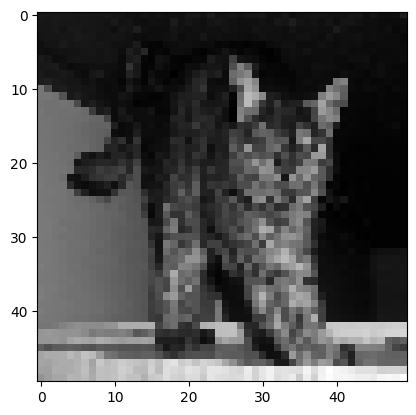

In [5]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1200], cmap="gray")
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
 
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            print(self._to_linear)
            ## Expected value is 2 * 2 * 128
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)
    
net = Net()


512


In [8]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i for i in training_data]).view(-1, 50, 50)
X = X/255.0

y = torch.Tensor([i for i in training_labels])

val_percent = 0.1
val_size = int(len(X) * val_percent)
print(val_size)

2494


C:\Users\ashis\AppData\Local\Temp\ipykernel_21464\3984365312.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  X = torch.Tensor([i for i in training_data]).view(-1, 50, 50)


In [9]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [18]:
def train(net):
    BATCH_SIZE = 50
    EPOCHS = 3

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i : i + BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i : i + BATCH_SIZE]

            net.zero_grad()
            outputs = net(batch_X)

            matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, batch_y)]
            in_sample_acc = matches.count(True)/len(matches)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)
        print("In-sample acc:",round(in_sample_acc, 2))


In [12]:
def test(net):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1, 1, 50, 50))

            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print('Accuracy: ', round(correct/total, 3))

In [19]:
net = Net()

train(net)
test(net)

512


  0%|          | 0/450 [00:00<?, ?it/s]

100%|██████████| 450/450 [00:52<00:00,  8.63it/s]


tensor(0.2499, grad_fn=<MseLossBackward0>)
In-sample acc: 1.0


100%|██████████| 450/450 [00:56<00:00,  8.03it/s]


tensor(0.2499, grad_fn=<MseLossBackward0>)
In-sample acc: 1.0


100%|██████████| 450/450 [00:50<00:00,  8.84it/s]


tensor(0.2499, grad_fn=<MseLossBackward0>)
In-sample acc: 1.0


100%|██████████| 2494/2494 [00:07<00:00, 341.14it/s]

Accuracy:  0.511


In [20]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(train_X))):
        real_class = torch.argmax(train_y[i])
        net_out = net(train_X[i].view(-1, 1, 50, 50))

        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1

print('Accuracy: ', round(correct/total, 3))

100%|██████████| 22452/22452 [01:16<00:00, 294.56it/s]

Accuracy:  0.524


In [21]:
def fwd_pass(X, y, train = False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    return acc, loss


In [26]:
def test(size = 32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y)
    return val_acc, val_loss

In [29]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 

loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 50
    EPOCHS = 3

    with open('model.log', 'a' ) as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                # print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")

                
                # just to show the above working, and then get out:
                if i % 10 == 0:
                    val_acc, val_loss = test(size= 50)
                    f.write(f"{MODEL_NAME},{int(time.time())},in_sample,{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

train(net)

512


  0%|          | 0/450 [00:00<?, ?it/s]

100%|██████████| 450/450 [01:46<00:00,  4.22it/s]


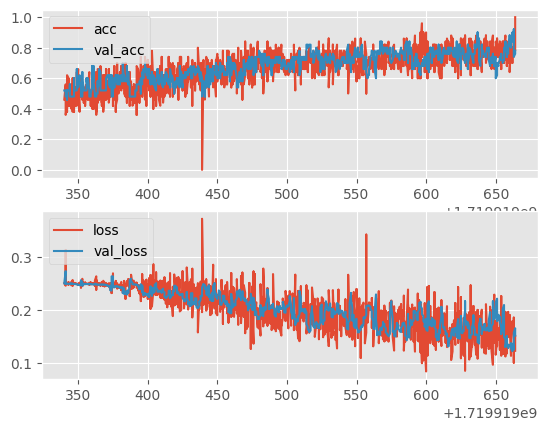

In [32]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

def create_acc_loss_graph(model_name):
    try:
        contents = open('model.log', 'r').read().split('\n')

        times = []
        accuracies = []
        losses = []

        val_accs = []
        val_losses = []

        for c in contents:
            if model_name in c:
                _, timestamp, tp, acc, loss, val_acc, val_loss = c.split(',')

                times.append(float(timestamp))
                accuracies.append(float(acc))
                losses.append(float(loss))

                val_accs.append(float(val_acc))
                val_losses.append(float(val_loss))

        fig = plt.figure()

        ax1 = plt.subplot2grid((2, 1), (0, 0))
        ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

        ax1.plot(times, accuracies, label='acc')
        ax1.plot(times, val_accs, label='val_acc')
        ax1.legend(loc=2)

        ax2.plot(times, losses, label='loss')
        ax2.plot(times, val_losses, label='val_loss')
        ax2.legend(loc=2)

        plt.show()

    except Exception as e:
        print(f"Error occurred: {str(e)}")

create_acc_loss_graph(MODEL_NAME)
